# 滑面识别程序 / Sliding surface identification program

## 0 一些准备工作 / Some preparation work

### 0.1 导入相关库 / Import related libraries
导入一些运行所必须的库 / Import some necessary libraries for operation

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.metrics as sm
from skimage import io, measure, morphology
from sklearn.cluster import KMeans, MiniBatchKMeans
import copy
from PIL import Image, ImageChops
import time

import alphashape

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn import metrics
from sklearn.cluster import DBSCAN


### 0.2 设置相关参数 / Set the relevant parameters

其中的 A, B, C, D, E, F 坐标如图所示，使用的是像素坐标，可用画图等软件获取该坐标。

The coordinates of A, B, C, D, E and F are shown in the figure. The pixel coordinates are used, and the coordinates can be obtained by software such as drawing.

![坐标 (小).png](<attachment:坐标 (小).png>)

In [2]:
# 总位移云图所在目录 / The directory of the total displkacement contour map
image_path = "./example_TDCM"

A_x, A_y = 600, 1687
B_x, B_y = 3262, 1687
C_x, C_y = 3262, 90
D_x, D_y = 2197, 90
E_x, E_y = 865, 1421
F_x, F_y = 600, 1421

# 保存的颜色为类似红色,其意义为只保存最接近该种颜色的颜色
# The color preserved is similar to red, which means that only the color closest to the color is preserved.
keep_of_color = np.array([0, 0, 0]) / 255.0
# 其他颜色直接设置other_color
# Other colors set other_color directly.
other_color = np.array([255, 255, 255]) / 255.0


## 1 滑块识别 / Sliding surface identification

### 1.1 使用图像分割识别包含其他块体的滑块 / Image segmentation is used to identify sliding block containing other blocks

In [3]:
# 定义函数用于识别包含其他块体的滑块
# A function is defined to identify the sliding block containing other blocks.
def get_block_with_noise(imgae_path):
    filename_of_image = image_path + "\\" + "total_displacement.jpg"

    num_of_color = 2
    color_of_keep = np.array([0, 0, 0]) / 255.0
    other_color = np.array([255, 255, 255]) / 255.0

    # 读取图片并显示
    image = io.imread(filename_of_image)

    # 读取图片每个像素点的信息(RGB值)
    data = image / 255.0
    # print("pre_data: \n", data)
    data = data.reshape(-1, 3)
    # print("lat_data: \n", data)

    # 开始对图片中的像素进行聚类
    # 最要想要留下的颜色个数
    color_use = num_of_color
    # 开始进行聚类
    # km = MiniBatchKMeans(color_use)
    km = KMeans(init='k-means++', n_clusters=color_use, random_state=0)
    km.fit(data)
    # 利用np.array的整数索引，用聚类中心点值，代替原来点的值
    new_data = km.cluster_centers_[km.predict(data)]
    # 获取查看剩下的color_use 种颜色
    # print("new_data: \n", new_data)
    color_set = np.array(list(set([tuple(t) for t in new_data])))
    # print("color_set:\n", color_set)

    # 计算聚类后的每种颜色与保留色的距离
    dist = []
    for i in range(len(color_set)):
        dist.append(np.sqrt(np.sum(np.square(color_set[i] - color_of_keep))))

    # print("dist:\n", dist)

    # 获取距离最小的下标
    index_min = dist.index(min(dist))
    # print("index_min: ", index_min)

    # 将new_data中除最小下标所对应的值之外的值变为指定颜色
    for i in range(len(new_data)):
        if tuple(new_data[i]) != tuple(color_set[index_min]):
            new_data[i] = other_color
        else:
            # new_data[i] = np.array([0, 0, 0])
            new_data[i] = color_of_keep

    # 重新设置图片
    image_new = new_data.reshape(image.shape)
    image_new_convert = np.array(np.round(image_new * 255), dtype='uint8')
    save_name_of_image = image_path + "\\cluster_image.jpg"
    io.imsave(save_name_of_image, image_new_convert)


In [4]:
get_block_with_noise(image_path)

### 1.2 使用连通区域标识面积去除其他块体 \ Use connected domain identification to remove other blocks

In [5]:
# 定义一个函数，去除多余滑块
# Define a function to remove redundant sliding blocks
def remove_noise_block(image_path):
    save_name_of_image = image_path + "\\cluster_image.jpg"
    # 使用cv2读取图片
    image = cv2.imread(save_name_of_image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opening = 255 - \
        cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    
    save_name_of_image = image_path + "\\cluster_image_without_noise.jpg"

    io.imsave(save_name_of_image, opening)

    # 再将图片反色 #
    im = Image.open(save_name_of_image)
    im_inverted = ImageChops.invert(im)
    im_inverted.save(save_name_of_image)

    # 对输入图像进行降噪，去除噪声干扰，然后再二值化 #
    # ----------- 第一个调试点, 用于出图 -----------# 出 反色之后的图
    im = cv2.imread(save_name_of_image)
    # print(im)
    blurred = cv2.GaussianBlur(im, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    t, binary = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # 将数组还原成图片 Image.fromarray方法 传入数组 和 通道
    img = Image.fromarray(binary)
    img.save(save_name_of_image)

    # 使用连通域阈值对图片进行去噪 #
    threshold = 35000  # ----------- 第二个调试点, 用于出图 -----------#
    # 读入图片
    img = cv2.imread(save_name_of_image, cv2.IMREAD_COLOR)
    GrayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 图片灰度化处理
    # 二值化图片
    ret, binary = cv2.threshold(GrayImage, 40, 255, cv2.THRESH_BINARY)
    # cv2.fingContours寻找图片轮廓信息
    """提取二值化后图片中的轮廓信息 ，返回值contours存储的即是图片中的轮廓信息，是一个向量，内每个元素保存
    了一组由连续的Point点构成的点的集合的向量，每一组Point点集就是一个轮廓，有多少轮廓，向量contours就有
    多少元素"""
    contours, hierarch = cv2.findContours(
        binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])  # 计算轮廓所占面积
        if area < threshold:  # 将area小于阈值区域填充背景色，由于OpenCV读出的是BGR值
            # 原始图片背景BGR值(84,1,68)
            cv2.drawContours(img, [contours[i]], -1, (0, 0, 0), thickness=-1)
            continue

    # cv2.imshow('Output',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 保存图片
    cv2.imwrite(save_name_of_image, img)

    # 在执行一次反色
    im = Image.open(save_name_of_image)
    im_inverted = ImageChops.invert(im)

    im_inverted.save(save_name_of_image)


In [6]:
remove_noise_block(image_path)

## 2 滑面识别 \ Sliding surface identification

### 2.1 识别滑块边界 \ Identify the slider boundary

#### 2.1.1 使用alpha shapes算法获取滑块边界 \ Use the alpha shapes algorithm to obtain the sliding block boundary

In [7]:
def get_black_point(image_file):
    # 打开图片文件
    img = Image.open(image_file).convert("RGB")
    array_of_image = np.asarray(img)
    black_point_array = []
    # print(array_of_image[0][0][0])

    for i in range(len(array_of_image)):
        for j in range(len(array_of_image[0])):
            if array_of_image[i][j][0] < 128:
                temp_point = [j, i]
                black_point_array.append(temp_point)
    # print(black_point_array[0])

    alpha_shape = alphashape.alphashape(black_point_array, 0.5)
    # print(alpha_shape)

    boundary_array = alpha_shape.exterior.coords[:]
    # print(shape(boundary_array))

    return boundary_array

### 2.2 去除滑块边界中边坡面部分 \ Remove the slope boundary in the slider boundary

In [8]:
# 2. 利用边坡边界的线段方程，去除大部分边坡边界
# Most of the slope boundaries are removed by using the line segment equation of the slope boundary
def get_init_slide(boundary_array):
    # print("boundary_array len is", len(boundary_array))
    slide_array = []
    for i in range(len(boundary_array)):
        k = (D_y - E_y) / (D_x - E_x)
        b = E_y - k * E_x
        x = boundary_array[i][0]
        y = boundary_array[i][1]
        error_range = 6
        if (y - error_range) <= (k * x + b) <= (y + error_range):
            # print("({:4.1f}, {:4.1f})".format(x, y))
            continue
        if y - 1 <= D_y <= y + 1:
            # print("({:4.1f}, {:4.1f})".format(x, y))
            continue
        if (F_x <= x <= E_x) and (y - 1 <= F_y <= y + 1):
            continue

        slide_array.append(boundary_array[i])
    return slide_array


In [9]:
# 3. 定义去除滑面噪点的函数
# Define the function to remove the noise of the sliding surface
def remove_noise_form_silde(slide_array):
    # 定义dbscan函数
    def dbscan_(data, r, min_samples):
        """实现DBSCAN算法

        Args:
            data (ndarray): 输入数据集
            r (float): 阈值半径
            min_samples (int): 点数阈值
        """
        db = DBSCAN(eps=r, min_samples=min_samples)
        clustering = db.fit(data)
        # 计算分簇
        labels = clustering.labels_.tolist()
        # # 计算分簇数
        # if -1 in labels:
        #     k = len(set(labels)) - 1
        # else:
        #     k = len(set(labels))
        # # 计算轮廓系数
        # if k == 0:
        #     dbscan_score = 0
        # else:
        #     dbscan_score = metrics.silhouette_score(X=data, labels=labels)

        return labels
    result = dbscan_(slide_array, 10, 10)
    # print(result[0])

    slide_label = result
    print("set slide is ", set(slide_label))
    label_sum = [0 for i in range(len(set(slide_label)) - 1)]
    slide_array_db = []
    # # 获取除噪点之外最短的一组
    # for i_ in range(len(slide_array)):
    #     if slide_label[i_] == -1:
    #         continue
    #     label_sum[slide_label[i_]] += 1
    
    # min_num_of_label = min(label_sum)
    # index_min_label = label_sum.index(min_num_of_label)

    for i_ in range(len(slide_array)):        
        if slide_label[i_] == -1: # or slide_array[i_] == index_min_label:
            continue
        slide_array_db.append(slide_array[i_])
    print("num_of_labels is ", label_sum)
    return slide_array_db


In [10]:
# 4. 对数组进行重新排序
# Reorder an array
def resort_slide(slide_array_w_noise):
    silde_left = []
    slide_right = []

    label = 1
    for i in range(1, len(slide_array_w_noise)):
        d = abs(slide_array_w_noise[i][1] - slide_array_w_noise[i - 1][1])
        if d >= 100:
            # print("ge")
            label = 0

        # print(label)
        if label == 0:
            silde_left.append(slide_array_w_noise[i])
        elif label == 1:
            slide_right.append(slide_array_w_noise[i])

    slide_array_resort = silde_left + slide_right

    slide_array = []

    return slide_array_resort


### 2.3 定义函数，获取滑动面 \ Define the function to obtain the sliding surface

In [11]:
# 定义一个函数，获取单张图片的滑动面
# Define a function to obtain the sliding surface of a single picture
def get_curve_of_slide(image_path):
    image_file = image_path + "\\cluster_image_without_noise.jpg"
    boundary_array = get_black_point(image_file=image_file)
    slide_array = get_init_slide(boundary_array=boundary_array)
    slide_array_w_noise = remove_noise_form_silde(slide_array=slide_array)
    slide_array_resort = resort_slide(slide_array_w_noise=slide_array_w_noise)
    x_of_slide = []
    y_of_slide = []
    for i_ in slide_array_resort:
        x_of_slide.append(i_[0])
        y_of_slide.append(i_[1])
    return x_of_slide, y_of_slide


In [12]:
x_i, y_i = get_curve_of_slide(image_path)
x_i_array = np.array(x_i)
y_i_array = np.array(y_i)
np.savetxt(image_path + "\\x_array.txt", x_i_array, fmt="%4d")
np.savetxt(image_path + "\\y_array.txt", y_i_array, fmt="%4d")


set slide is  {0, 1, -1}
num_of_labels is  [0, 0]


## 3 绘制滑动面 \ Draw the sliding surface
### 3.1 绘制单独的滑动面 \ Draw single sliding surface

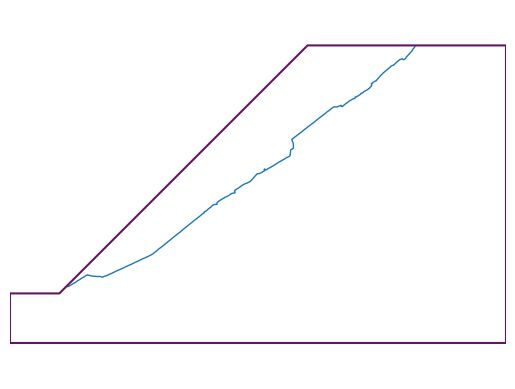

In [13]:
plt.axis('off')
plt.axis("equal")
# plt.xlim(-10, 2732)
# plt.ylim(-10, 1677)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
fig = plt.gcf()

max_y = max(A_y, B_y, C_y, D_y, E_y, F_y)
A_y_, B_y_, C_y_, D_y_, E_y_, F_y_ = max_y - A_y, max_y - B_y, max_y - C_y, max_y - D_y, max_y - E_y, max_y - F_y

plt.plot((A_x, B_x, C_x, D_x, E_x, F_x, A_x), (A_y_, B_y_, C_y_,
                                               D_y_, E_y_, F_y_, A_y_), linewidth=1.5, color="#621661", zorder=2)

y_i_ = []
for i in y_i:
    y_i_.append(max_y - i)
plt.plot(x_i, y_i_, linewidth=1, zorder=1)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.margins(0, 0)
fig.savefig(image_path + "\\slide_surface.pdf",
            format='pdf', dpi=1200, pad_inches=0, transparent=1)
plt.show()


### 3.2 将滑动面与总位移云图、最大剪切应变云图分别绘制 \ Draw the sliding surface with the total displacement contour map and the maximum shear strain contour map respectively
#### 3.2.1 滑动面-最大剪切应变云图 \ Sliding surface-maximum shear strain contour map

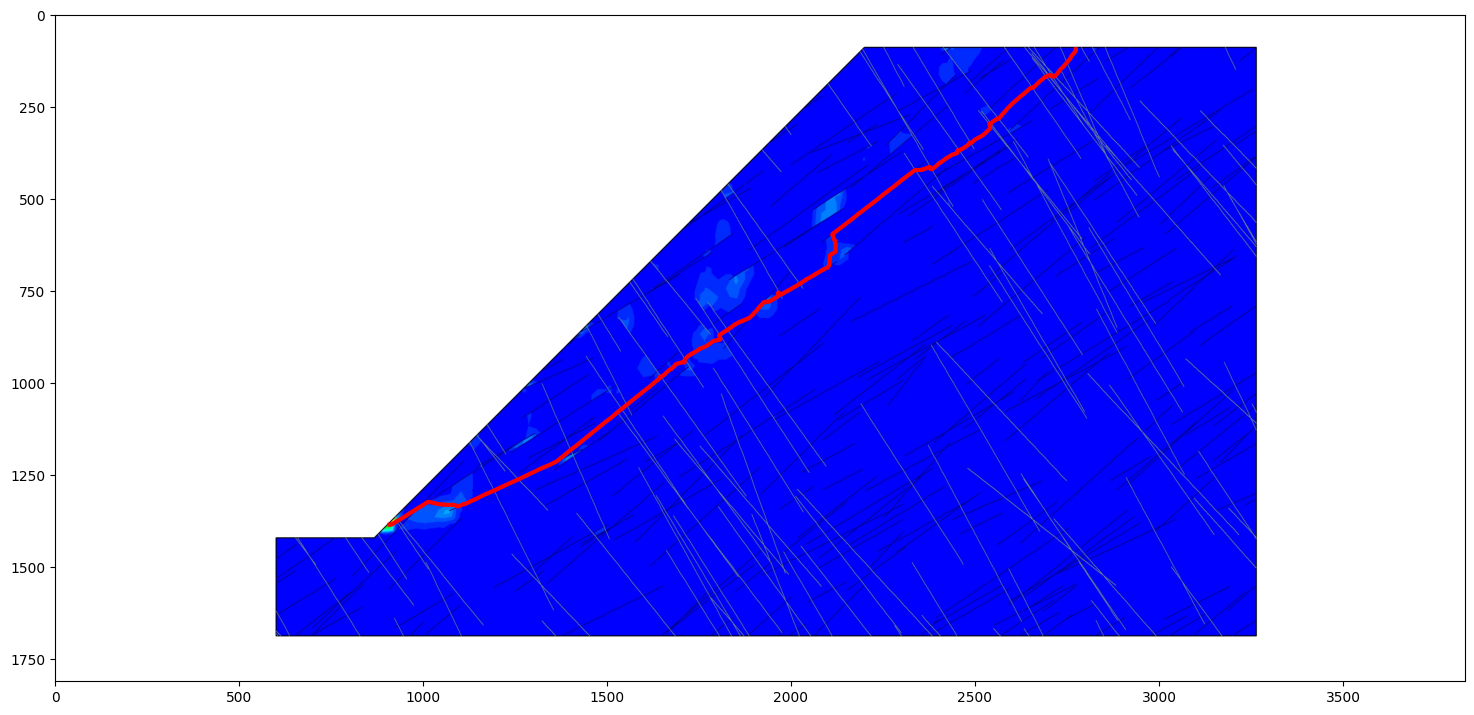

In [14]:
maximum_shear_strain_image = image_path + "\\maximum_shear_strain.jpg"
# 为了避免每次都要重新运行上面的代码，这里选择从文件中读取x, y的数据
x_i = np.loadtxt(image_path + "\\x_array.txt", dtype=float)
y_i = np.loadtxt(image_path + "\\y_array.txt", dtype=float)

img = Image.open(maximum_shear_strain_image)
plt.figure("Image", figsize=(19.16, 8.65))  # 图像窗口名称
plt.imshow(img)
plt.plot(x_i, y_i, linewidth=3, color="red")
plt.savefig(image_path + "\\mss_slide.pdf",
            format='pdf', dpi=1200, pad_inches=0)


#### 3.2.2 滑动面-总位移云图 \ Sliding surface-total displacement contour map

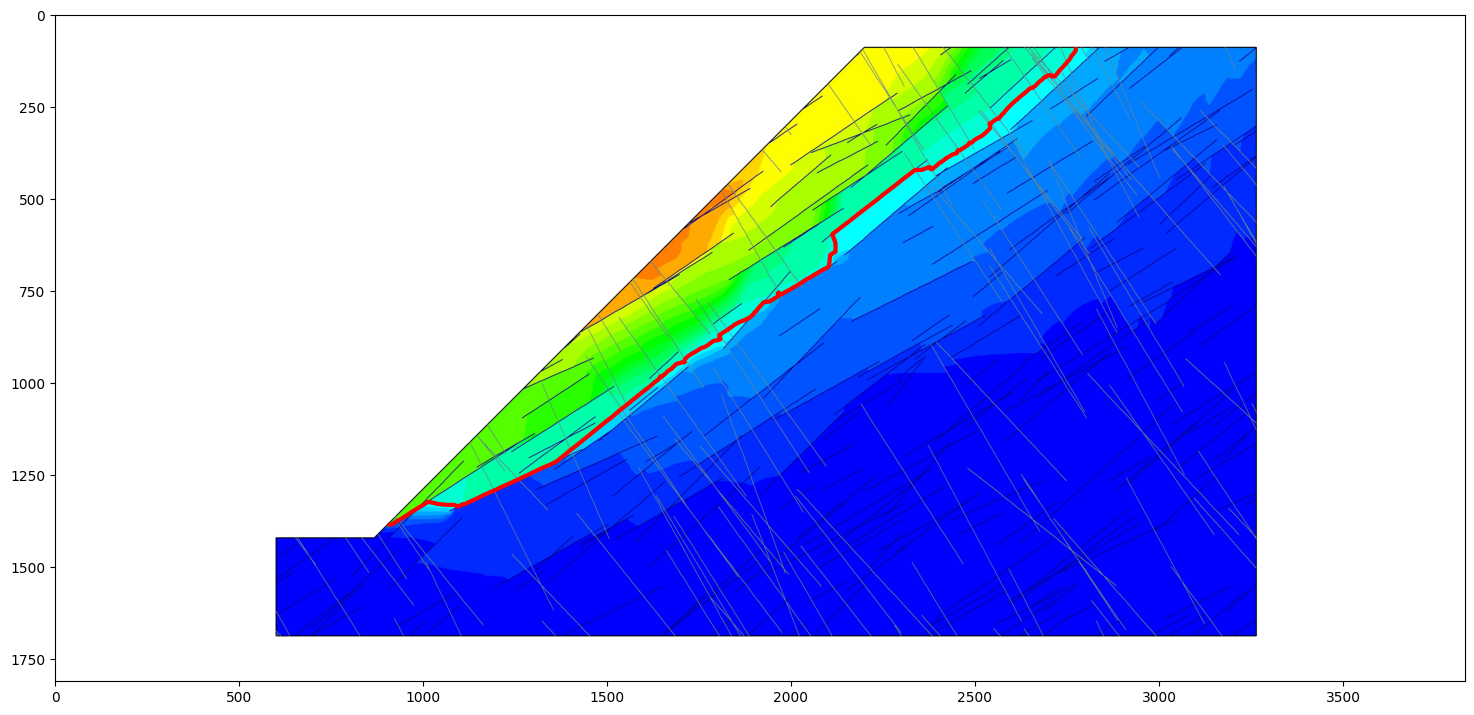

In [15]:
total_displacement_image = image_path + "\\total_displacement_.jpg"
img = Image.open(total_displacement_image)
plt.figure("Image", figsize=(19.16, 8.65))  # 图像窗口名称
plt.imshow(img)
plt.plot(x_i, y_i, linewidth=3, color="red")
plt.savefig(image_path + "\\td_silde.pdf",
            format='pdf', dpi=1200, pad_inches=0)


# END